In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import ta
import ta.momentum
import ta.trend
import ta.volume

Final balance: 13649.552577887072$
Period: [2017-08-17] -> [2024-06-22]
Initial balance: 1000.0 $

--- General Information ---
Final balance: 13649.55 $
Sharpe Ratio: 1.09
Performance: 1264.96 %
Worst Drawdown: -40.09%
Total trades on the period: 86
Average Profit: 4.2 %
Global Win rate: 38.37 %

--- Trades Information ---
Mean Trades per day: 0.03
Mean Trades Duration: 10 days 01:27:54.418604651
Best trades: +96.53 % the 2017-11-20 12:00:00 -> 2017-12-21 12:00:00
Worst trades: -10.52 % the 2018-12-23 10:00:00 -> 2018-12-27 18:00:00
Total Good trades on the period: 33
Total Bad trades on the period: 53
Average Good Trades result: 17.16 %
Average Bad Trades result: -3.86 %
Mean Good Trades Duration: 19 days 23:01:49.090909091
Mean Bad Trades Duration: 3 days 21:32:49.811320754

--- Trades reasons ---
open_reason
Market buy    86
close_reason
market sell    86


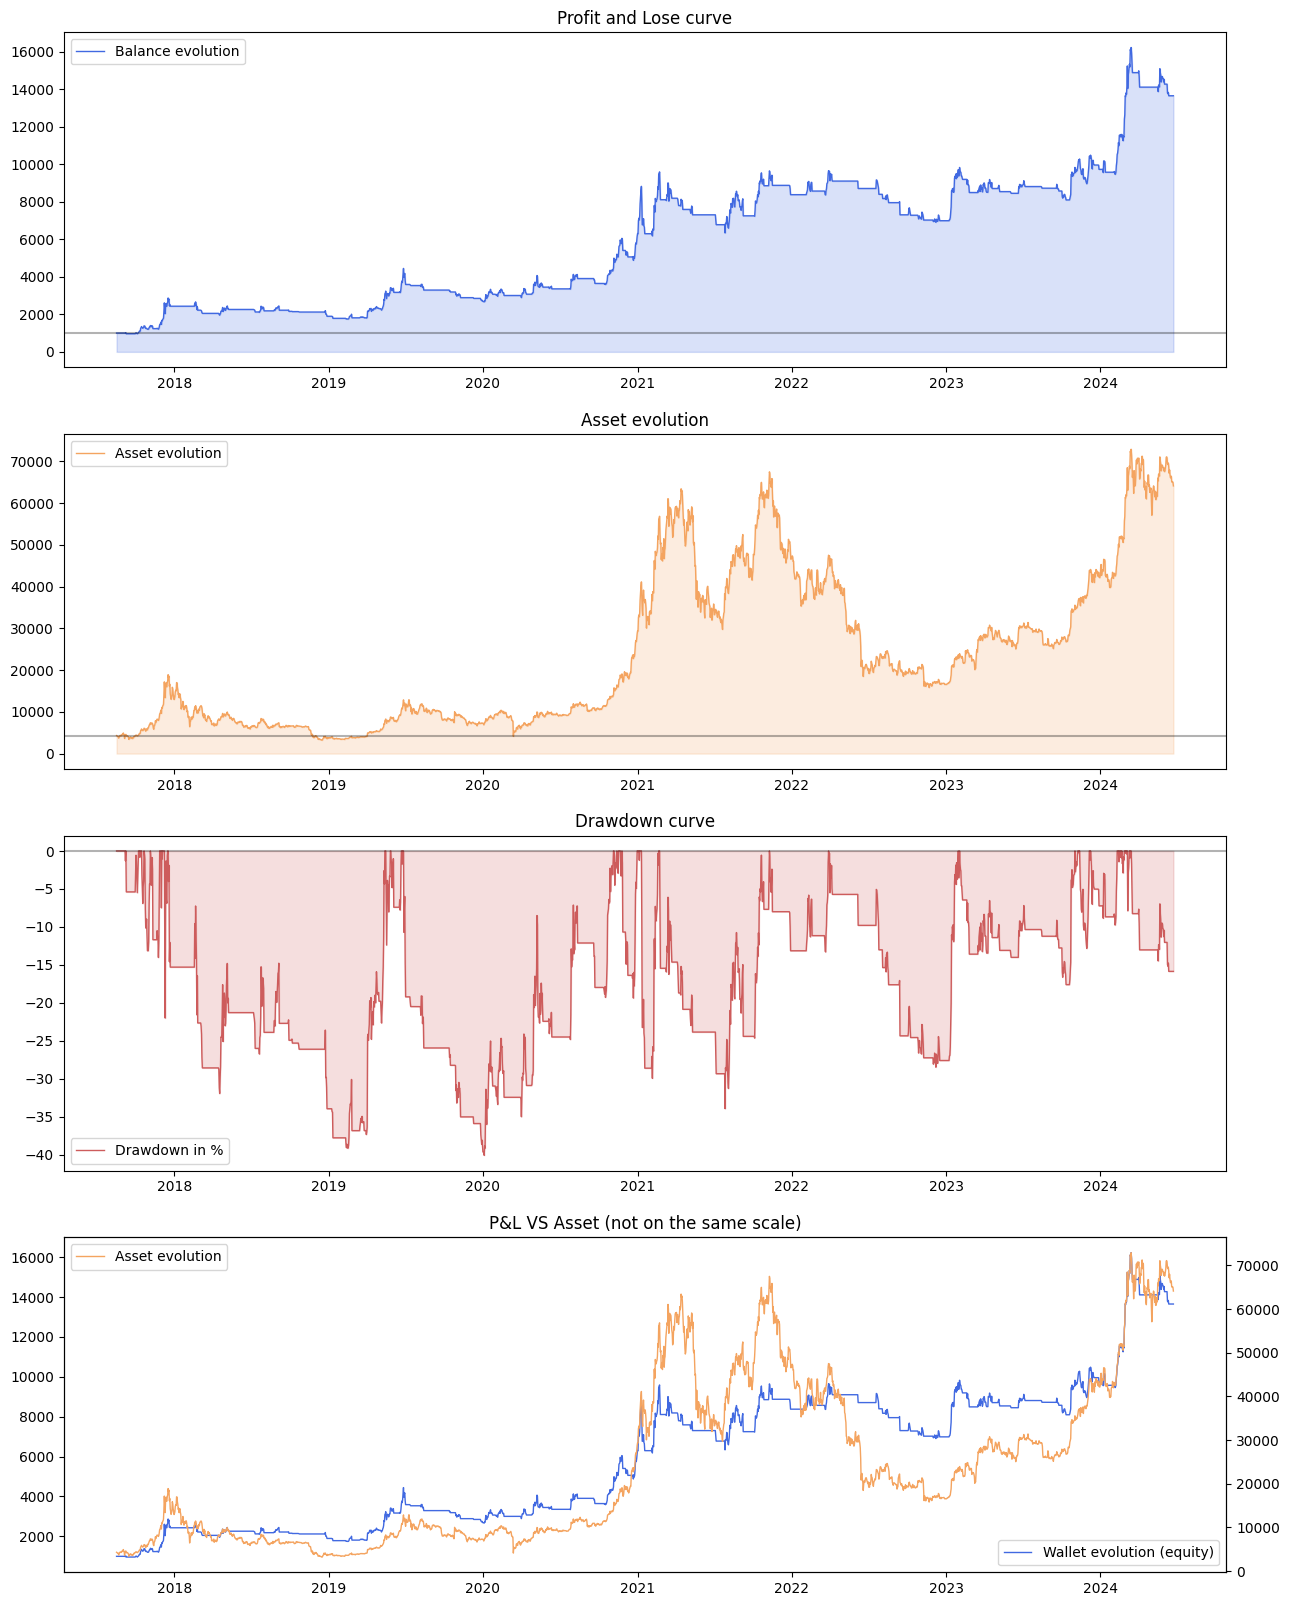

In [6]:
class BacktestCrossMA:
    def __init__(self) -> None:
        self.df = pd.DataFrame()
        self.trades=[]
        self.days=[]

    def load_data(self, path):
        self.df = pd.read_csv(path)
        self.df["date"] = pd.to_datetime(self.df["date"], unit="ms")
        self.df = self.df.set_index(self.df["date"])
        del self.df["date"]

    def populate_indicators(self):
        self.df['ma80'] = self.df['close'].rolling(80).mean()
        self.df['ma100'] = self.df['close'].rolling(100).mean()
        self.df['ma250'] = self.df['close'].rolling(250).mean()
        self.df['ma200'] = self.df['close'].rolling(200).mean()
        self.df['donchian_h']=ta.volatility.donchian_channel_hband(high=self.df["high"],low=self.df["low"],close=self.df["close"])
        self.df['donchian_l']=ta.volatility.donchian_channel_lband(high=self.df["high"],low=self.df["low"],close=self.df["close"])
        self.df["RSI"]=ta.momentum.rsi(close=self.df["close"],window=14)
        self.df['MACDHist']=ta.trend.macd_diff(close=self.df["close"])
        self.df['adx']=ta.trend.adx(high=self.df["high"],low=self.df["low"],close=self.df["close"])

    def populate_signals(self):
        self.df['buy_signal'] = False
        self.df['sell_signal'] = False
        self.df.loc[(self.df["high"]==self.df['donchian_h'])
                    & (self.df["ma80"]>self.df["ma100"])
                    & (self.df["ma100"]>self.df["ma200"])
                    & (self.df["close"]>self.df["ma100"])

                    , 'buy_signal'] = True
        self.df.loc[(self.df['close'] < self.df['ma200']), 'sell_signal'] = True

    def run_backtest(self):
        balance = 1000
        position = None
        asset = "BTC"
        fees=0.001
        self.trades=[]
        self.days=[]
        previous_day=-1

        for index, row in self.df.iterrows():
            current_day = index.day
            if previous_day != current_day:
                temp_balance = balance
                if position:
                    close_price = row["close"]
                    trade_result = (close_price - position["open_price"]) / position[
                        "open_price"
                    ]
                    close_size = (
                        position["open_size"] + position["open_size"] * trade_result
                    )
                    fee = close_size * fees
                    close_size = close_size - fee
                    temp_balance = temp_balance + close_size - position["open_size"]
                self.days.append({
                    "day":index.date(),
                    "balance":temp_balance,
                    "price":row['close']
                })
            previous_day = current_day
            if position is None and row['buy_signal']:
                open_price = row['close']
                open_size=balance
                fee=open_size * fees
                open_size-=fee
                balance = balance - fee
                position = {
                    'open_price': open_price,
                    'open_size': open_size,
                    'open_fee' :fee,
                    'open_date':index,
                    'balance':balance,
                    'reason': "Market buy",
                }
                

            elif position and row['sell_signal']:
                close_price = row['close']
                trade_result = (close_price - position['open_price']) / position['open_price']
                close_size= position['open_size']+position['open_size']* trade_result
                fee = fees * close_size
                close_size=close_size -fee
                balance = balance + close_size - position['open_size']
                
                self.trades.append(
                    {
                    'open_price': position['open_price'],
                    'open_size': position['open_size'],
                    'open_fee' :position['open_fee'],
                    'close_size':close_size,
                    'close_fee':fee,
                    'close_date':index,
                    'open_date':position['open_date'],
                    'open_balance':position['balance'],
                    'close_balance':balance,
                    'open_reason': position['reason'],
                    'close_reason':"market sell",
                    }
                )
                
                position=None
                
            
        
        print(f"Final balance: {balance}$")
    def backtest_analysis(self):
        df_trades = pd.DataFrame(self.trades)
        df_days = pd.DataFrame(self.days)

        if df_trades.empty:
            raise Exception("No trades found")
        if df_days.empty:
            raise Exception("No days found")

        df_days['evolution'] = df_days['balance'].diff()
        df_days['daily_return'] = df_days['evolution']/df_days['balance'].shift(1)

        df_trades["trade_result"] = df_trades["close_size"] - df_trades["open_size"]
        df_trades["trade_result_pct"] = (
            df_trades["trade_result"] / df_trades["open_size"]
        )
        df_trades["trades_duration"] = df_trades["close_date"] - df_trades["open_date"]

        df_days["balance_ath"] = df_days["balance"].cummax()
        df_days["drawdown"] = df_days["balance_ath"] - df_days["balance"]
        df_days["drawdown_pct"] = df_days["drawdown"] / df_days["balance_ath"]

        total_trades = len(df_trades)
        total_days = len(df_days)

        good_trades = df_trades.loc[df_trades["trade_result"] > 0]
        total_good_trades = len(good_trades)
        avg_profit_good_trades = good_trades["trade_result_pct"].mean()
        mean_good_trades_duration = good_trades["trades_duration"].mean()
        global_win_rate = total_good_trades / total_trades

        bad_trades = df_trades.loc[df_trades["trade_result"] < 0]
        total_bad_trades = len(bad_trades)
        avg_profit_bad_trades = bad_trades["trade_result_pct"].mean()
        mean_bad_trades_duration = bad_trades["trades_duration"].mean()

        max_days_drawdown = df_days["drawdown_pct"].max()
        initial_balance = df_days.iloc[0]["balance"]
        final_balance = df_days.iloc[-1]["balance"]
        balance_evolution = (final_balance - initial_balance) / initial_balance
        mean_trades_duration = df_trades["trades_duration"].mean()
        avg_profit = df_trades["trade_result_pct"].mean()
        mean_trades_duration = df_trades['trades_duration'].mean()
        mean_trades_per_days = total_trades/total_days

        best_trade = df_trades.loc[df_trades["trade_result_pct"].idxmax()]
        worst_trade = df_trades.loc[df_trades["trade_result_pct"].idxmin()]

        sharpe_ratio = (365**(0.5) * df_days['daily_return'].mean())/df_days['daily_return'].std()

        print(f"Period: [{df_days.iloc[0]['day']}] -> [{df_days.iloc[-1]['day']}]")
        print(f"Initial balance: {round(initial_balance,2)} $")

        print("\n--- General Information ---")
        print(f"Final balance: {round(final_balance,2)} $")
        print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        print(f"Performance: {round(balance_evolution*100,2)} %")
        print(f"Worst Drawdown: -{round(max_days_drawdown*100, 2)}%")
        print(f"Total trades on the period: {total_trades}")
        print(f"Average Profit: {round(avg_profit*100, 2)} %")
        print(f"Global Win rate: {round(global_win_rate*100, 2)} %")

        print("\n--- Trades Information ---")
        print(f"Mean Trades per day: {round(mean_trades_per_days, 2)}")
        print(f"Mean Trades Duration: {mean_trades_duration}")
        print(f"Best trades: +{round(best_trade['trade_result_pct']*100, 2)} % the {best_trade['open_date']} -> {best_trade['close_date']}")
        print(f"Worst trades: {round(worst_trade['trade_result_pct']*100, 2)} % the {worst_trade['open_date']} -> {worst_trade['close_date']}")
        print(f"Total Good trades on the period: {total_good_trades}")
        print(f"Total Bad trades on the period: {total_bad_trades}")
        print(f"Average Good Trades result: {round(avg_profit_good_trades*100, 2)} %")
        print(f"Average Bad Trades result: {round(avg_profit_bad_trades*100, 2)} %")
        print(f"Mean Good Trades Duration: {mean_good_trades_duration}")
        print(f"Mean Bad Trades Duration: {mean_bad_trades_duration}")

        print("\n--- Trades reasons ---")
        print(df_trades["open_reason"].value_counts().to_string())
        print(df_trades["close_reason"].value_counts().to_string())

        self.df_days = df_days
        self.df_trades = df_trades

    def plot_equity_vs_asset(self):
        df_days = self.df_days.copy()
        df_days = df_days.set_index('day')
        fig, ax_left = plt.subplots(figsize=(15, 20), nrows=4, ncols=1)

        ax_left[0].title.set_text("Profit and Lose curve")
        ax_left[0].plot(df_days['balance'], color='royalblue', lw=1)
        ax_left[0].fill_between(df_days['balance'].index, df_days['balance'], alpha=0.2, color='royalblue')
        ax_left[0].axhline(y=df_days.iloc[0]['balance'], color='black', alpha=0.3)
        ax_left[0].legend(['Balance evolution'], loc ="upper left")

        ax_left[1].title.set_text("Asset evolution")
        ax_left[1].plot(df_days['price'], color='sandybrown', lw=1)
        ax_left[1].fill_between(df_days['price'].index, df_days['price'], alpha=0.2, color='sandybrown')
        ax_left[1].axhline(y=df_days.iloc[0]['price'], color='black', alpha=0.3)
        ax_left[1].legend(['Asset evolution'], loc ="upper left")

        ax_left[2].title.set_text("Drawdown curve")
        ax_left[2].plot(-df_days['drawdown_pct']*100, color='indianred', lw=1)
        ax_left[2].fill_between(df_days['drawdown_pct'].index, -df_days['drawdown_pct']*100, alpha=0.2, color='indianred')
        ax_left[2].axhline(y=0, color='black', alpha=0.3)
        ax_left[2].legend(['Drawdown in %'], loc ="lower left")

        ax_right = ax_left[3].twinx()

        ax_left[3].title.set_text("P&L VS Asset (not on the same scale)")
        ax_left[3].plot(df_days['balance'], color='royalblue', lw=1)
        ax_right.plot(df_days['price'], color='sandybrown', lw=1)
        ax_left[3].legend(['Wallet evolution (equity)'], loc ="lower right")
        ax_right.legend(['Asset evolution'], loc ="upper left")
        plt.show()
        

bt = BacktestCrossMA()
bt.load_data('../Data/BTC-USDT2H.csv')
bt.populate_indicators()
bt.populate_signals()
bt.run_backtest()
bt.backtest_analysis()
bt.plot_equity_vs_asset()